# Fase de pré-processamento

- Entrada: arquivo exportado pelo scraper da UOL
- Saída: Arquivo estruturado pronto para submissão ao modelo de aprendizagem

In [60]:
import sys

sys.path.append('..')

from hyperparameters.TeamStrength import *
from itertools import compress

from enum import Enum
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json

plt.style.use('seaborn')

%matplotlib inline

In [2]:
# Carga do arquivo de saída do scraper
file_src = '../output/br-league.json'

with open(file_src) as f:
    raw_data = json.load(f)

class Seasons(Enum):
    FIRST = 45
    SECOND = 90
    
def getEventsInfo(events, team, season):
    filtered = [(event["team"] == team and int(event["time"]) <= season.value) for event in events]
    return filtered.count(True)

def addTacticalType(s, data, i, is_home):
    prefix = 'h' if is_home else 'a'
    if (s == 'OFF'):
        data["{}_substitution_{}_tactical_type_off".format(prefix, i)] = 1
        data["{}_substitution_{}_tactical_type_def".format(prefix, i)] = 0
        data["{}_substitution_{}_tactical_type_na".format(prefix, i)] = 0
    elif (s == 'DEF'):
        data["{}_substitution_{}_tactical_type_off".format(prefix, i)] = 0
        data["{}_substitution_{}_tactical_type_def".format(prefix, i)] = 1
        data["{}_substitution_{}_tactical_type_na".format(prefix, i)] = 0
    else:
        data["{}_substitution_{}_tactical_type_off".format(prefix, i)] = 0
        data["{}_substitution_{}_tactical_type_def".format(prefix, i)] = 0
        data["{}_substitution_{}_tactical_type_na".format(prefix, i)] = 1

def addInterval(t, data, i, is_home):
    prefix = 'h' if is_home else 'a'
    if (t >= 0 and t <= 15):
        data["{}_substitution_{}_interval_0".format(prefix, i)] = 1
        data["{}_substitution_{}_interval_1".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_2".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_3".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_4".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_5".format(prefix, i)] = 0
    elif (t > 15 and t <= 30):
        data["{}_substitution_{}_interval_0".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_1".format(prefix, i)] = 1
        data["{}_substitution_{}_interval_2".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_3".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_4".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_5".format(prefix, i)] = 0
    elif (t > 30 and t <= 45):
        data["{}_substitution_{}_interval_0".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_1".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_2".format(prefix, i)] = 1
        data["{}_substitution_{}_interval_3".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_4".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_5".format(prefix, i)] = 0
    elif (t > 45 and t <= 60):
        data["{}_substitution_{}_interval_0".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_1".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_2".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_3".format(prefix, i)] = 1
        data["{}_substitution_{}_interval_4".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_5".format(prefix, i)] = 0
    elif (t > 60 and t <= 75):
        data["{}_substitution_{}_interval_0".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_1".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_2".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_3".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_4".format(prefix, i)] = 1
        data["{}_substitution_{}_interval_5".format(prefix, i)] = 0
    elif (t > 75 and t <= 90):
        data["{}_substitution_{}_interval_0".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_1".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_2".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_3".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_4".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_5".format(prefix, i)] = 1
        
def getYearFromDate(date):
    return date[:4]

def getSubsInfoAndLabelsHome(data, substitutions):
    MAX_SUBSTITUTIONS = 3
    
    # Home substitutions:
    s = [subs["team"] == data["home_team_name"] for subs in substitutions]
    d = list(compress(substitutions, s))

    for i in range(MAX_SUBSTITUTIONS):
        try:
            data["h_substitution_{}_score_away".format(i)] = d[i]["score_away"]
            data["h_substitution_{}_score_home".format(i)] = d[i]["score_home"]
            data["h_substitution_{}_time".format(i)] = 45 if d[i]["time"] == 'INTERVALO' else d[i]["time"]
            data["h_substitution_{}_number".format(i)] = d[i]["number_of_sub"]
            data["h_substitution_{}_is_home".format(i)] = 1 if d[i]["team"] == data["home_team_name"] else 0
            addInterval(int(d[i]["time"]), data, i, data["h_substitution_{}_is_home".format(i)])
            addTacticalType(d[i]["tactical_type"], data, i, data["h_substitution_{}_is_home".format(i)])
            data["y_{}_effectiveness".format(i)] = d[i]["effectiveness"]
            if (data["h_substitution_{}_interval_1".format(i)] == None):
                break
        except:
            data["h_substitution_{}_score_away".format(i)] = 0
            data["h_substitution_{}_score_home".format(i)] = 0
            data["h_substitution_{}_time".format(i)] = 0
            data["h_substitution_{}_number".format(i)] = 0
            data["h_substitution_{}_is_home".format(i)] = 0
            data["y_{}_effectiveness".format(i)] = 0
            data["h_substitution_{}_interval_0".format(i)] = 0
            data["h_substitution_{}_interval_1".format(i)] = 0
            data["h_substitution_{}_interval_2".format(i)] = 0
            data["h_substitution_{}_interval_3".format(i)] = 0
            data["h_substitution_{}_interval_4".format(i)] = 0
            data["h_substitution_{}_interval_5".format(i)] = 0
            data["h_substitution_{}_tactical_type_off".format(i)] = 0
            data["h_substitution_{}_tactical_type_def".format(i)] = 0
            data["h_substitution_{}_tactical_type_na".format(i)] = 0
            
def getSubsInfoAndLabelsAway(data, substitutions):
    MAX_SUBSTITUTIONS = 3
    
    # Home substitutions:
    s = [subs["team"] != data["home_team_name"] for subs in substitutions]
    d = list(compress(substitutions, s))

    for i in range(MAX_SUBSTITUTIONS):
        try:
            data["a_substitution_{}_score_away".format(i)] = d[i]["score_away"]
            data["a_substitution_{}_score_home".format(i)] = d[i]["score_home"]
            data["a_substitution_{}_time".format(i)] = 45 if d[i]["time"] == 'INTERVALO' else d[i]["time"]
            data["a_substitution_{}_number".format(i)] = d[i]["number_of_sub"]
            data["a_substitution_{}_is_home".format(i)] = 1 if d[i]["team"] == data["home_team_name"] else 0
            addInterval(int(d[i]["time"]), data, i, data["a_substitution_{}_is_home".format(i)])
            addTacticalType(d[i]["tactical_type"], data, i, data["a_substitution_{}_is_home".format(i)])
            #data["y_{}_effectiveness".format(i)] = d[i]["effectiveness"]
            if (data["a_substitution_{}_interval_1".format(i)] == None):
                break
        except:
            data["a_substitution_{}_score_away".format(i)] = 0
            data["a_substitution_{}_score_home".format(i)] = 0
            data["a_substitution_{}_time".format(i)] = 0
            data["a_substitution_{}_number".format(i)] = 0
            data["a_substitution_{}_is_home".format(i)] = 0
            #data["y_{}_effectiveness".format(i)] = 0
            data["a_substitution_{}_interval_0".format(i)] = 0
            data["a_substitution_{}_interval_1".format(i)] = 0
            data["a_substitution_{}_interval_2".format(i)] = 0
            data["a_substitution_{}_interval_3".format(i)] = 0
            data["a_substitution_{}_interval_4".format(i)] = 0
            data["a_substitution_{}_interval_5".format(i)] = 0
            data["a_substitution_{}_tactical_type_off".format(i)] = 0
            data["a_substitution_{}_tactical_type_def".format(i)] = 0
            data["a_substitution_{}_tactical_type_na".format(i)] = 0
            
def dataFormatter(raw_data):
    output = []
    for d in raw_data:
        data = {}
        data["date"] = d["date"]
        data["home_team_name"] = d["home"]
        data["away_team_name"] = d["away"]
        data["home_win"] = d["home_win"]
        data["home_team_strength"] = TeamStrength().buildParam(d["home"], getYearFromDate(d["date"]))
        data["ycards_home_1st_season"] = getEventsInfo(d["yellowcards"],  d["home"], Seasons.FIRST)
        data["ycards_away_1st_season"] = getEventsInfo(d["yellowcards"],  d["away"], Seasons.FIRST)
        data["ycards_home_2nd_season"] = getEventsInfo(d["yellowcards"],  d["home"], Seasons.SECOND)
        data["ycards_away_2nd_season"] = getEventsInfo(d["yellowcards"],  d["away"], Seasons.SECOND)
        data["rcards_home_1st_season"] = getEventsInfo(d["redcards"],     d["home"], Seasons.FIRST)
        data["rcards_away_1st_season"] = getEventsInfo(d["redcards"],     d["away"], Seasons.FIRST)
        data["rcards_home_2nd_season"] = getEventsInfo(d["redcards"],     d["home"], Seasons.SECOND)
        data["rcards_away_2nd_season"] = getEventsInfo(d["redcards"],     d["away"], Seasons.SECOND)
        data["agoals_home_1st_season"] = getEventsInfo(d["againstgoals"], d["home"], Seasons.FIRST)
        data["agoals_away_1st_season"] = getEventsInfo(d["againstgoals"], d["away"], Seasons.FIRST)
        data["agoals_home_2nd_season"] = getEventsInfo(d["againstgoals"], d["home"], Seasons.SECOND)
        data["agoals_away_2nd_season"] = getEventsInfo(d["againstgoals"], d["away"], Seasons.SECOND)
        data["penaltys_home_1st_season"] = getEventsInfo(d["penaltys"],   d["home"], Seasons.FIRST)
        data["penaltys_away_1st_season"] = getEventsInfo(d["penaltys"],   d["away"], Seasons.FIRST)
        data["penaltys_home_2nd_season"] = getEventsInfo(d["penaltys"],   d["home"], Seasons.SECOND)
        data["penaltys_away_2nd_season"] = getEventsInfo(d["penaltys"],   d["away"], Seasons.SECOND)
        getSubsInfoAndLabelsHome(data, d["substitutions"])
        getSubsInfoAndLabelsAway(data, d["substitutions"])
        output.append(data)
    return output
    
data = dataFormatter(raw_data)
json_stringify = json.dumps(data)
df = pd.read_json(json_stringify)

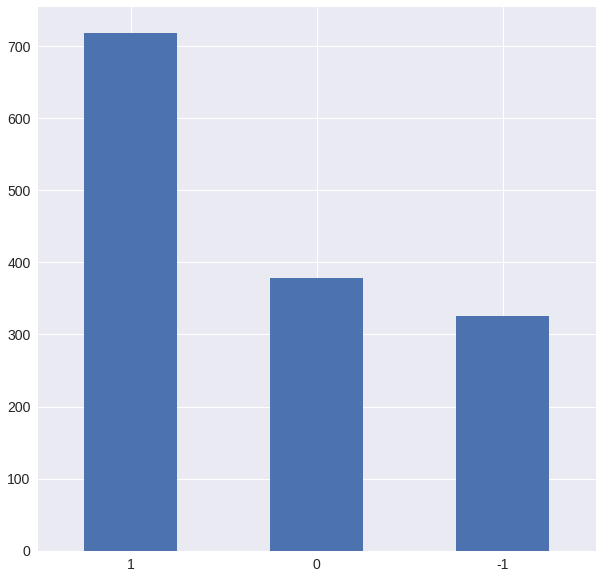

In [3]:
df["home_win"].value_counts().plot.bar(rot=0, figsize=(10,10), fontsize=14)

In [4]:
# O estudo se concentrará nos casos onde o time da casa venceu. Portanto será feito o split no dataset
# para trabalhar com os 718 casos.

df = df[df["home_win"] == 1]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 0 to 1420
Columns: 108 entries, a_substitution_0_interval_0 to ycards_home_2nd_season
dtypes: float64(1), int64(105), object(2)
memory usage: 611.4+ KB


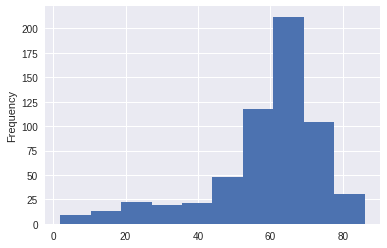

In [5]:
df_filtered = df[df["h_substitution_0_time"] != 0]
df_filtered["h_substitution_0_time"].apply(lambda x : 45 if x == 'INTERVALO' else int(x)).plot.hist()

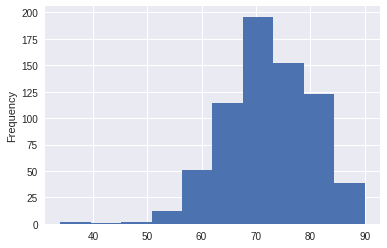

In [6]:
df_filtered = df[df["h_substitution_1_time"] != 0]
df_filtered["h_substitution_1_time"].apply(lambda x : 45 if x == 'INTERVALO' else int(x)).plot.hist()

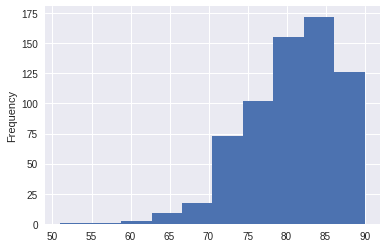

In [7]:
df_filtered = df[df["h_substitution_2_time"] != 0]
df_filtered["h_substitution_2_time"].apply(lambda x : 45 if x == 'INTERVALO' else int(x)).plot.hist()

In [8]:
from sklearn.model_selection import train_test_split

target_columns = [
    'y_0_effectiveness',
    'y_1_effectiveness',
    'y_2_effectiveness'
]

Y = df.filter(target_columns, axis=1)
try:
    X = df.drop(columns=target_columns, axis=1, inplace=True)
except:
    pass
X = df.drop(columns=(['away_team_name', 'home_team_name', 'date']), axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [9]:
X_train.head()

,a_substitution_0_interval_0,a_substitution_0_interval_1,a_substitution_0_interval_2,a_substitution_0_interval_3,a_substitution_0_interval_4,a_substitution_0_interval_5,a_substitution_0_is_home,a_substitution_0_number,a_substitution_0_score_away,a_substitution_0_score_home,...,penaltys_home_1st_season,penaltys_home_2nd_season,rcards_away_1st_season,rcards_away_2nd_season,rcards_home_1st_season,rcards_home_2nd_season,ycards_away_1st_season,ycards_away_2nd_season,ycards_home_1st_season,ycards_home_2nd_season
75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,6,0,2
73,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,2,0,1
137,0,0,1,0,0,0,0,1,0,0,...,1,1,1,1,0,0,2,2,0,1
323,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,1,3,3,4
680,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,2,3,2,3


In [12]:
from skmultilearn.problem_transform import LabelPowerset

target = {}

# Transformação dos dados multilabel para uma classe
target["y"], target["y_test"], target["y_train"] = LabelPowerset().transform(Y), \
                                                   LabelPowerset().transform(Y_test), \
                                                   LabelPowerset().transform(Y_train)

## Visualização da distribuição do target (y_train)

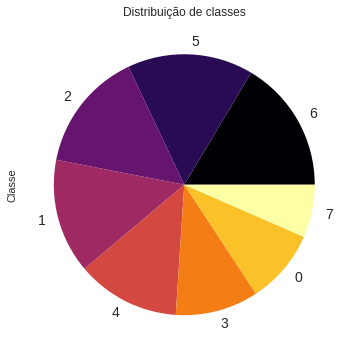

In [13]:
target_view = pd.DataFrame(columns=['Classe'], data=target["y"])
target_view['Classe'].value_counts().plot(kind='pie', figsize=(12,6), fontsize=14, title='Distribuição de classes', colormap='inferno')

# Feature selection

In [100]:
# Links úteis http://minerandodados.com.br/index.php/2018/05/21/feature-selection-bala-de-prata/

PERCENTILE = 25

from skmultilearn.problem_transform import LabelPowerset
from sklearn.feature_selection import SelectPercentile, f_classif

fs = SelectPercentile(f_classif, percentile=PERCENTILE)
fs.fit(X_train, target["y_train"])
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)
x = pd.DataFrame(X_train_fs)
x.head()


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 6 20 28 29 30 34 60 61 62 74 75 76 89] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,3.0,0.0,2.0,0.0,1.0,0.0,77.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,63.0,0.0,...,0.0,0.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,81.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,70.0,0.0,...,1.0,0.0,1.0,3.0,0.0,2.0,1.0,0.0,0.0,88.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,3.0,0.0,2.0,0.0,1.0,0.0,73.0
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


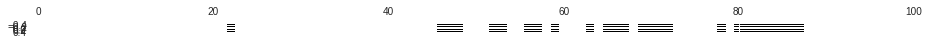

In [101]:
mask = fs.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

# Implementação e avaliação dos Classificadores

In [199]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

parameters = [
    {
        "classifier": [RandomForestClassifier()],
        "classifier__criterion": ['entropy', 'gini'],
        "classifier__n_estimators": [25, 50, 75],
        "classifier__bootstrap": [False, True],
        "classifier__max_depth": [3, 5, 10],
        "classifier__max_features": ['auto', 0.1, 0.2, 0.3]
    },
    {
        "classifier": [KNeighborsClassifier()],
        "classifier__algorithm": ['ball_tree', 'kd_tree', 'brute'],
        "classifier__n_neighbors": [3, 5, 11, 19],
        "classifier__weights": ['uniform', 'distance'],
    },
    {
        "classifier": [SVC()],
        "classifier__C": [1, 10, 100, 1000],
        "classifier__gamma": [1, 0.1, 0.001, 0.0001],
        "classifier__kernel": ['linear','rbf']
    }
]

temp = target["y_train"]

clf = GridSearchCV(LabelPowerset(), parameters, scoring="accuracy", cv=5)
clf.fit(X_train_fs, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LabelPowerset(classifier=None,
                                     require_dense=[True, True]),
             iid='warn', n_jobs=None,
             param_grid=[{'classifier': [RandomForestClassifier(bootstrap=True,
                                                                class_weight=None,
                                                                criterion='gini',
                                                                max_depth=10,
                                                                max_features=0.3,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_sample...
                                          

In [215]:
pred = clf.predict(X_test_fs)

print(classification_report(Y_test, pred))
print("Accuracy score: {:.6f}".format(accuracy_score(Y_test, pred)))
print("Best params: {}\n".format(grid_search.best_params_))

              precision    recall  f1-score   support

           0       0.94      0.72      0.81        81
           1       0.77      0.90      0.83        84
           2       0.91      0.77      0.84        93

   micro avg       0.86      0.80      0.83       258
   macro avg       0.87      0.80      0.83       258
weighted avg       0.87      0.80      0.83       258
 samples avg       0.68      0.66      0.66       258

Accuracy score: 0.629630
Best params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 50}



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
